# Прогноз оттока клиентов в фитнес-центре

# Описание проекта
Сеть фитнес-центров **«Культурист-датасаентист»** разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. **Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.**

# Задачи проекта

**Основные задачи проекта:**

* Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* Проанализировать основные признаки, наиболее сильно влияющие на отток;
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
* Выделить целевые группы клиентов;
* Предложить меры по снижению оттока;
* Определить другие особенности взаимодействия с клиентами.

# Описание полученных данных

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

**Данные клиента за предыдущий до проверки факта оттока месяц:**
* `gende` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первогообращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятийup_visits' — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

# Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')  

# Загружаем данные

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')
data.head(15)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


**Поменяем регистр в названии столбцов**

In [3]:
data.columns = data.columns.str.lower()
data.head(7)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0


**Посмотрим на данные**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

**Посмотрим на числовые значения**

In [5]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Посмотрим на дубликаты**

In [6]:
data.duplicated().sum()

0

**Вывод**

Данные в порядке, дубликатов и пропусков нету. Привели название столбцов в нижний регистр для удобства.

# Исследовательский анализ данных

## Изучим признаки, средних значений и стандартных отклонений

Выводим информацию по значениям

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Что видим:**

* Пол клиентов распределен практически **поровну**.
* Около **85%** клиентов проживают/работают рядом с фитнес-центром.
* Почти **половина** клиентов являются сотрудниками компаний-партнеров.
* Около **30%** клиентов пришли по приглашению друзей.
* Около **10%** клиентов без указаного контактного номера телефона.
* Около половины клиентов имеют абонемент на **1 месяц из 12 месяцов возможных**. Среднее значение длительности абонента **4.6 месяца.**
* Около **41%** клиентов посещают групповые занятия.
* Средний возраст клиентов **29-30 лет**.
* Среднее значение доп.продаж клиенту - **147**.
* Среднее значение срока до конца абонемента - **4.3 месяца**.
* Среднее время с момента первого обращения - **3.7 месяца**.
* Средняя частота посещений в неделю за всё время - **1.8 раз в неделю**.
* Средняя частота посещений в неделю за прошедщий месяц - **1.7 раз в неделю**.
* Средний отток - **26%**.

## Посмотрим на распределение признаков среди оставщихся и ушедших клиентов

Посмотрим на среднее значение признаков по группам клиентов

In [8]:
data.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Промежуточный вывод**

**Из группированной таблицы по оставщимся и ушедшим клиентам мы видим следующее:**

* Пол клиентов распределен **одинаково**.
* Среди ушедших клиентов на **10%** больше тех, кто живет/работает не в районе фитнес-центра.
* Среди ушедших клиентов на почти **20%** меньше тех, кто является сотрудником организации-партнера.
* Среди ушедших клиентов почти в **два раза** меньше тех, кто пришел от друга.
* Среднее значение длительности абонементов у постоянных клиентов **5.7 месяца**, а у ушедших - **1.7 месяца**.
* Ушедшие клиенты почти в **два раза** меньше посещали групповые занятия.
* Средний возраст ушедших клиентов меньше, чем у оставшихся и составляет **26-27 лет**.
* Ушедшие клиенты меньше тратили на доп.услуги фитнес-центра. Среднее значение доп.продаж у постоянных клиентов **158**, а у ушедших **115**.
* Среднее количество месяцев до конца абонемента у постоянных клиентов **5.2 месяца**, а у ушедших **1.6 месяца**.
* Среднее количество месяцев с первого обращение у постоянных - **4.7 месяца**, у ушедших **0.9 месяца**.
* Постоянные клиенты в среднем посещают фитнес-центр **2 раза в неделю**, а ушедшие клиенты - **1-1.4 раз в неделю**.

## Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [9]:
list_for_plot = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']

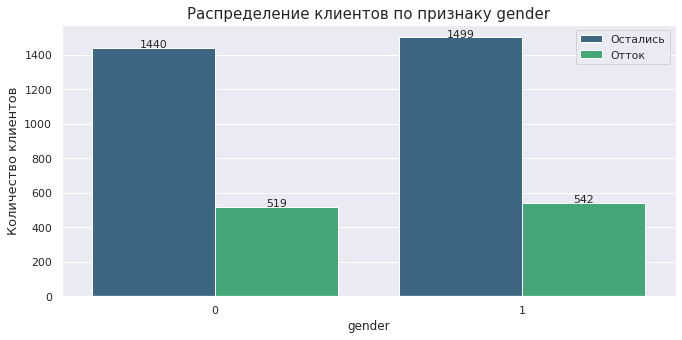


 доля ушедших 


,gender,total,churn,share
0,0,1959,519,0.26
1,1,2041,542,0.27


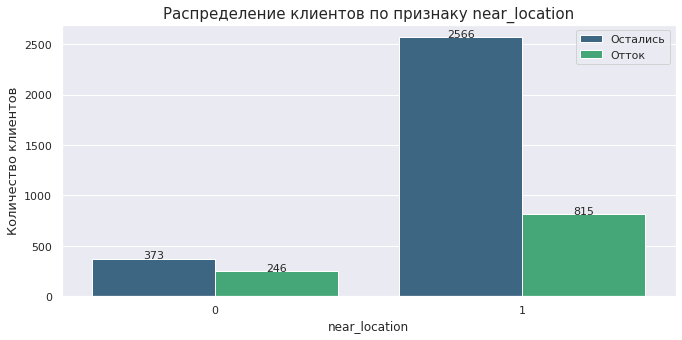


 доля ушедших 


,near_location,total,churn,share
0,0,619,246,0.40
1,1,3381,815,0.24


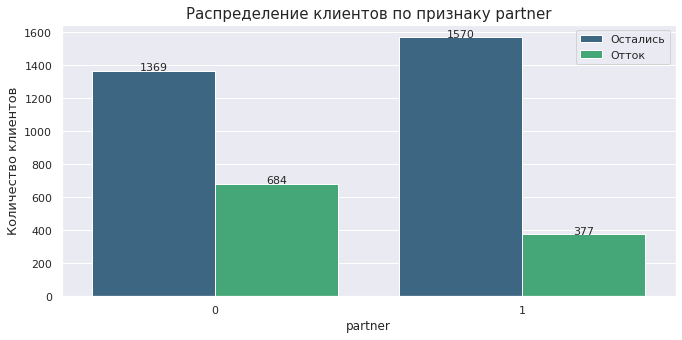


 доля ушедших 


,partner,total,churn,share
0,0,2053,684,0.33
1,1,1947,377,0.19


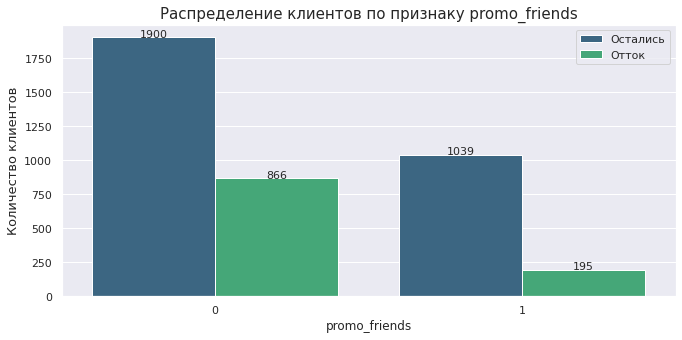


 доля ушедших 


,promo_friends,total,churn,share
0,0,2766,866,0.31
1,1,1234,195,0.16


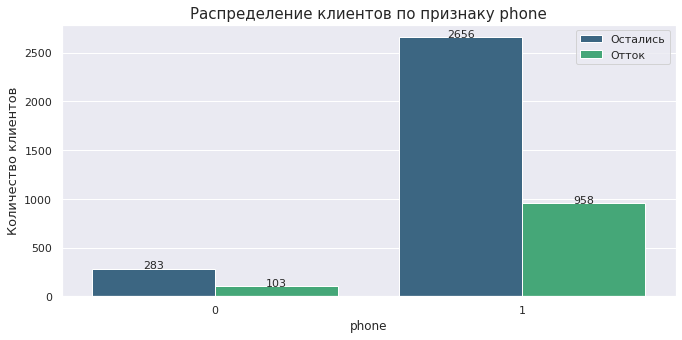


 доля ушедших 


,phone,total,churn,share
0,0,386,103,0.27
1,1,3614,958,0.27


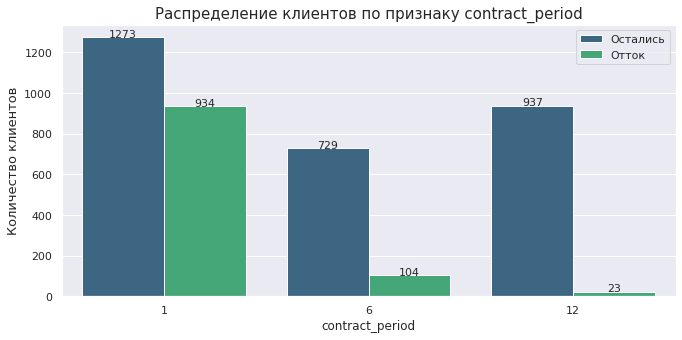


 доля ушедших 


,contract_period,total,churn,share
0,1,2207,934,0.42
1,6,833,104,0.12
2,12,960,23,0.02


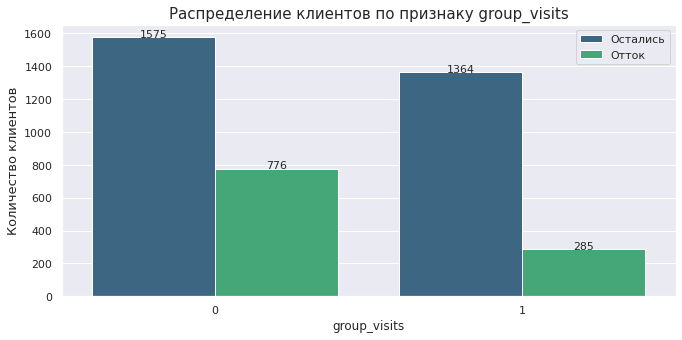


 доля ушедших 


,group_visits,total,churn,share
0,0,2351,776,0.33
1,1,1649,285,0.17


In [10]:
for feature in list_for_plot:
    countplt, ax = plt.subplots(figsize = (11,5))
    ax =sns.countplot(x = feature, data=data, palette='viridis', hue='churn')
    ax.set_title(f'Распределение клиентов по признаку {feature}',fontsize = 15)
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Количество клиентов', fontsize = 13)
    for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width() / 2,
                 rect.get_height()+ 0.25,
                 rect.get_height(),
                 horizontalalignment='center', 
                 fontsize = 11)
    plt.legend(['Остались', 'Отток'])
    plt.show()
    print('')
    share = data.groupby(feature).agg({'churn': ['count', 'sum']}).reset_index()
    share.columns = [feature, 'total', 'churn']
    share['share'] = round(share['churn'] / share['total'], 2)
    print('\033[7;30m доля ушедших \033[0m')
    display(share)

**Промежуточный вывод**

* Как и в предыдущем пункте, половой признак и наличие контактной информации не влияют на отток клиентов - доли равны как среди оставшихся клиентов, так и попавших в отток
* Чаще уходили в отток клиенты которые:
    * у которых **НЕТ** фитнес-клуба поблизости
    * **НЕ** являются сотрудником компании-партнёра клуба
    * записались на первое занятие без промокода
    * **НЕ** посещали групповые занятия
    * и у которых длительность текущего абонемента составляет один месяц

**Рассмотрим числовые признаки**

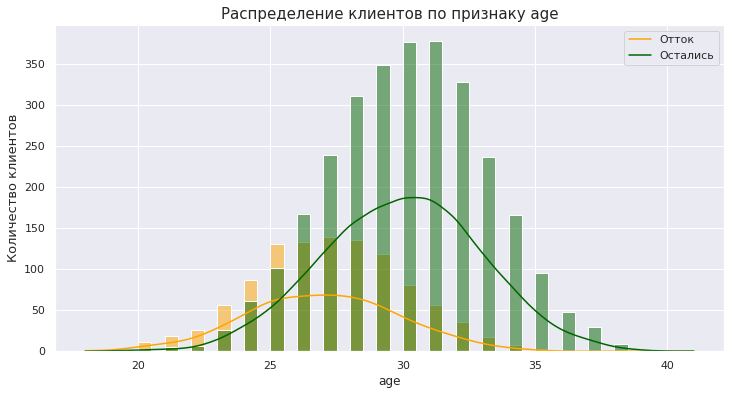

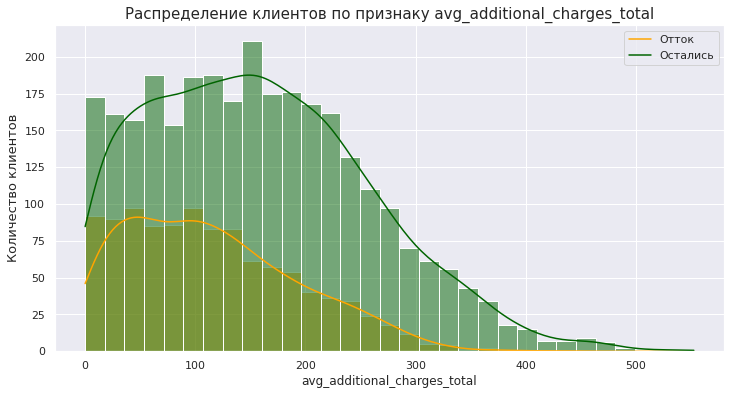

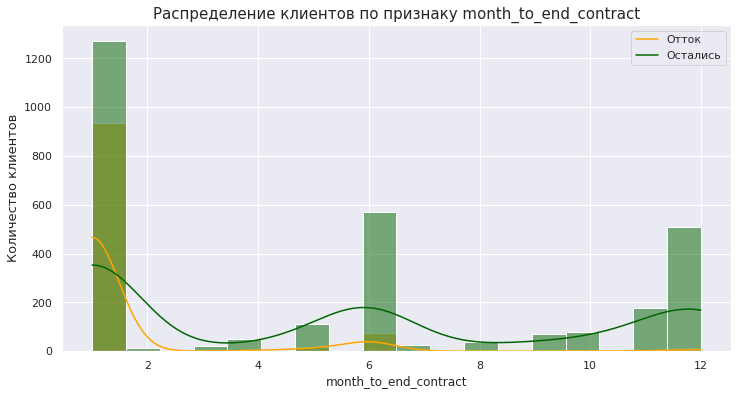

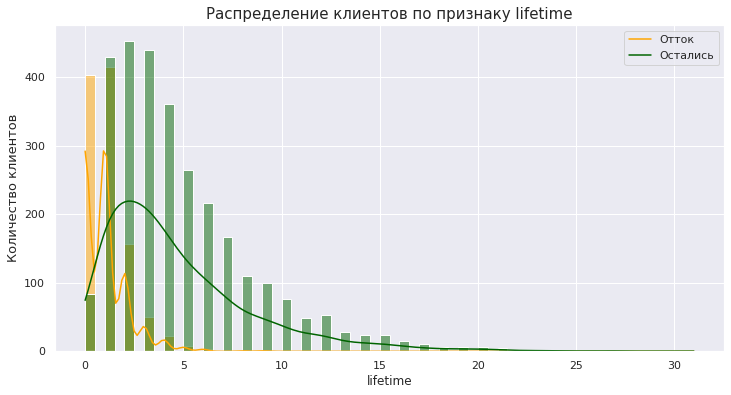

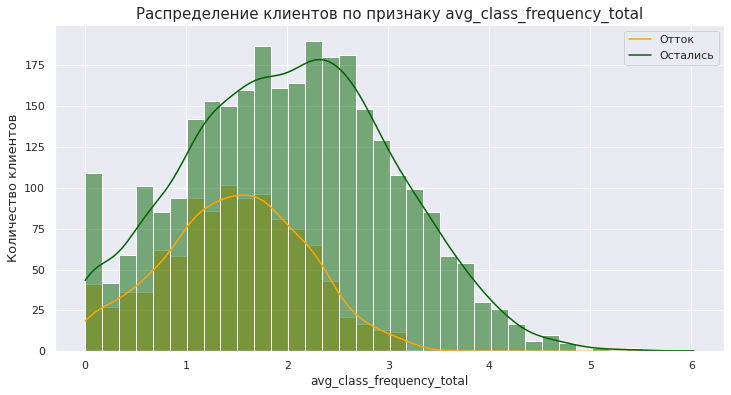

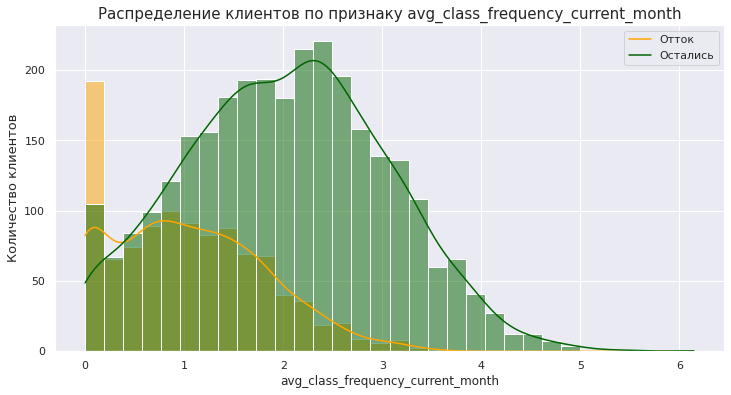

In [11]:
for column in data.drop('churn', axis = 1).columns:
    if column not in list_for_plot:
        hist, ax = plt.subplots(figsize = (12,6))
        ax = sns.histplot(x = column, data=data, palette=['darkgreen', 'orange'], hue='churn', kde=True)
        ax.set_title(f'Распределение клиентов по признаку {column}',fontsize = 15)
        ax.set_xlabel(f'{column}')
        ax.set_ylabel('Количество клиентов', fontsize = 13)
        plt.legend(['Отток', 'Остались'])
        plt.show()

**Среди данных признаков, чаще попадают в отток клиенты:**

* в возрасте до **27 лет**
* редко пользующиеся дополнительными услугами (либо тратящие небольшие суммы). Здесь прослеживается закономерность, что чем больше клиент тратит на дополнительные услуги, тем меньше доля клиентов, попавших в отток
* у которых до окончания действия абонемента остался месяц
* которые посещяют фитнес-клуб на протяжении **1-2 месяцев**
* которые занимаются спортов **1-2 раза в неделю**, а за предыдущий месяц не сходили в фитнес-центр **ни разу** или **1 раз**.

## Матрица корреляции признаков

Построим матрицу корреляции признаков

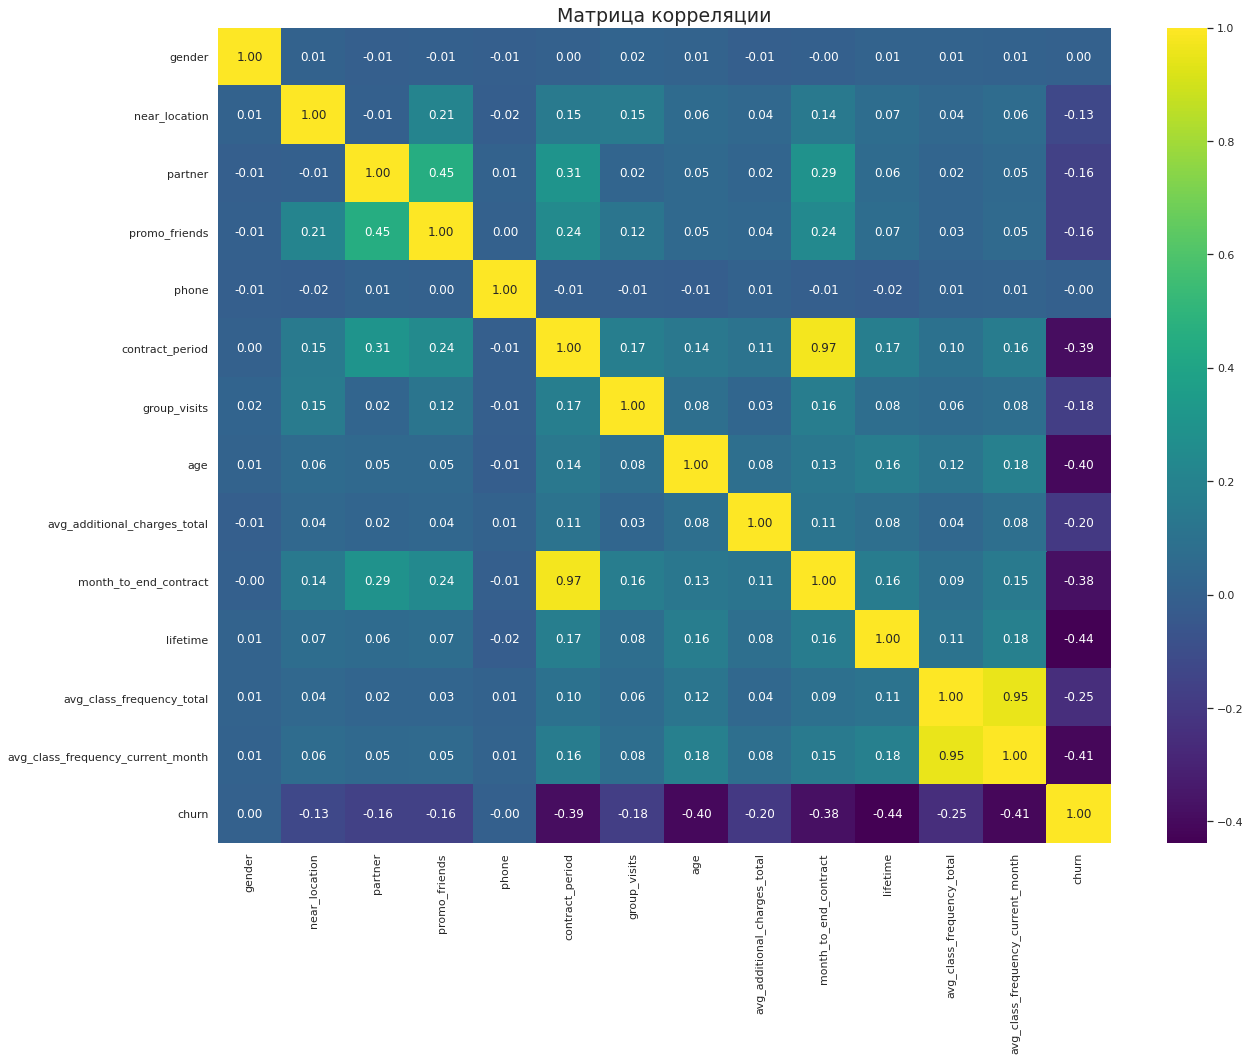

In [12]:
corr_matrix = data.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix , annot = True, fmt = '0.2f', cmap='viridis')
plt.title('Матрица корреляции', fontsize=19)
plt.show()

Уберем два мультиколлинирующих признака и сохраним в отдельный датасет

In [13]:
data_for_model = data.drop(['month_to_end_contract','avg_class_frequency_total'], axis=1)

Посмотрим на матрицу бещ мультиколлинирующих признаков

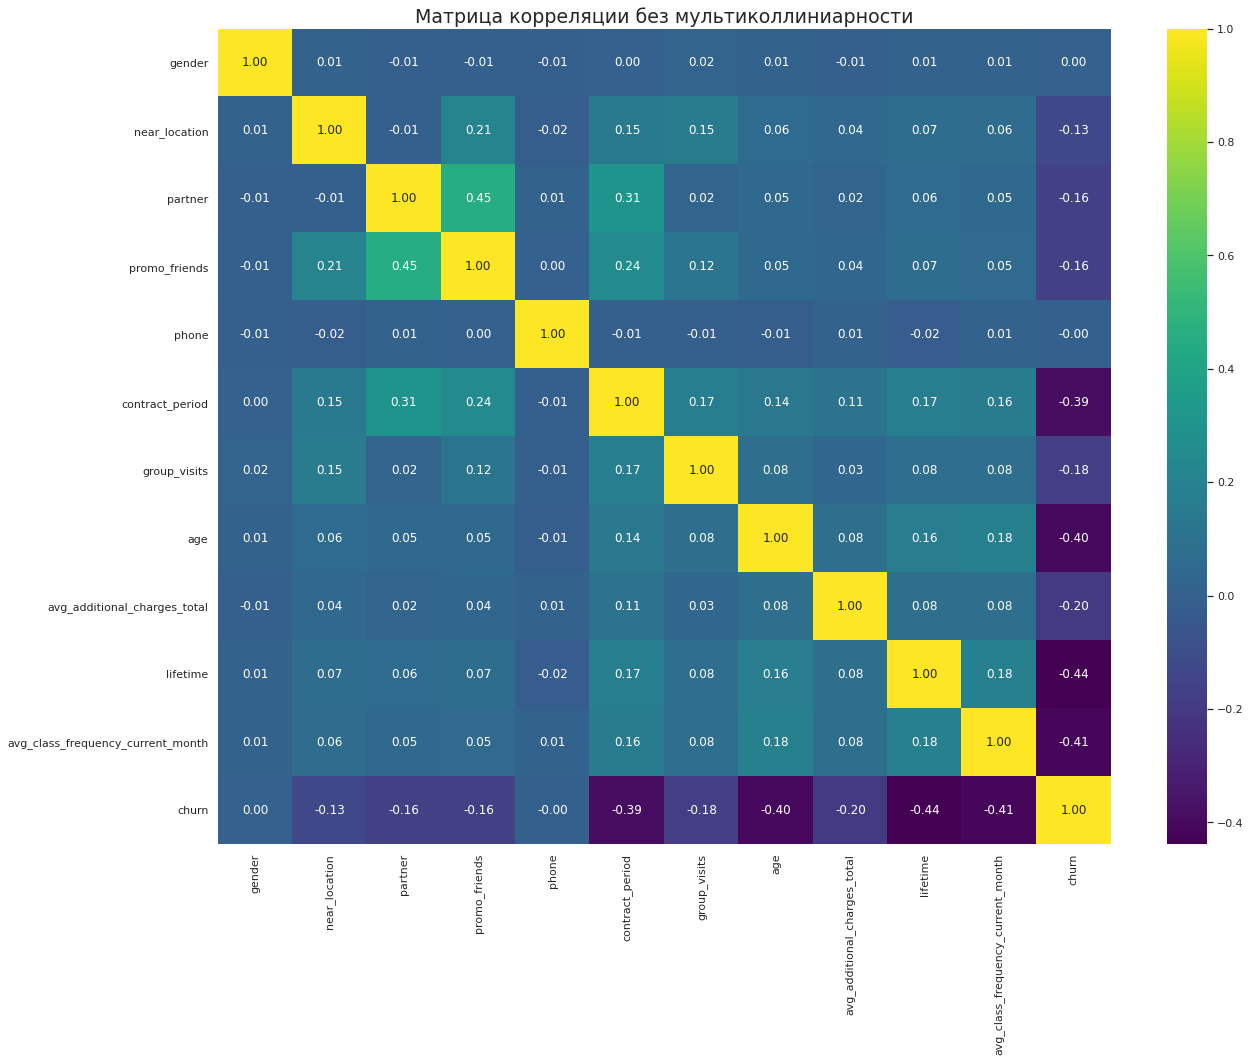

In [14]:
corr_matrix_check = data_for_model.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix_check , annot = True, fmt = '0.2f', cmap='viridis')
plt.title('Матрица корреляции без мультиколлиниарности', fontsize=19)
plt.show()

**Промежуточный вывод**

**На матрице корреляции мы видим следующее:**

* Две пары признаков показывают мультиколлиниарность - `avg_class_frequency_total` (частота посещений в неделю за всё время) `avg_class_frequency_current_month` (частота посещений в неделю за предыдущий месяц), `contract_period` (длительность текущего абонемента) и `month_to_end_contract` (количество месяцев до окончания абонемента).

**Убрав сильно коллирирующие признаки мы можем сказать следующее:**

* Пол клиента и наличие контактного номера телефона никак не влияет отток.
* Наиболее коррелирующие признаки с оттоком - время с первого обращения, частота посещения тренировок, возраст и длительность абонемента.
* Слабая корреляционная связь у признаков с оттоком - выручка с доп.услуг, групповые зантяния, приглашение друзей, партнерство.
* Близкое расположение имеет минимальную корреляционную связь с оттоком.
* Так же, стоит отметить видимую корреляционную связь между клиентами-партнерами и клиентов приглашенных друзьями, приглашенными друзьями и близким расположением, длительностью абонемента и партнерами.
* Остальные признаки показывают слабую корреляционную связь.

# Модель прогнозирования оттока клиентов

# Разбиваем данные на обучающую и валидационную выборки

Cоздадём переменную **'Х'** с признаками и переменную **'y'** c целевой переменной

In [15]:
X = data.drop('churn', axis=1)
y = data['churn']

Разделяем данные на обучающую и валидационную выборки и применим стандартизацию для тестовой выборки

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Обучение моделей и сравнение метрик

Обучаем модель логистической регрессии и выведим результат метрик

In [17]:
logistic_model = LogisticRegression(random_state=0)
logistic_model.fit(X_train_st, y_train)

logistic_predictions = logistic_model.predict(X_test_st)

print('Метрики Логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logistic_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logistic_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logistic_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, logistic_predictions)))

Метрики Логистической регрессии
Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84


Обучаем модель c помощью случайного леса и выведим результат метрик

In [18]:
r_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
r_forest_model.fit(X_train_st, y_train)

r_forest_predictions = r_forest_model.predict(X_test_st)

print('Метрики Случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, r_forest_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, r_forest_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, r_forest_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, r_forest_predictions)))

Метрики Случайного леса
Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


**Вывод**

**Логистическая регрессия** и **Случайный лес** показали одинаковую долю правильных ответов, но **Логистическая регрессия** показывает лучшую точность и полноту и F1-меру.

Следовательно, мы можем утверждать, что с помощью **Логистической регрессии** мы сможем предсказывать отток клиента с вероятность **чуть больше 90%**.

# Кластеризация клиентов

Cоздадим новый датафрейм без столбца **'churn'** и переменную в которой будут хранится список признаков 

In [19]:
data_for_c = data.drop(['churn'], axis=1)
data_columns_list = data_for_c.columns
data_for_c.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078


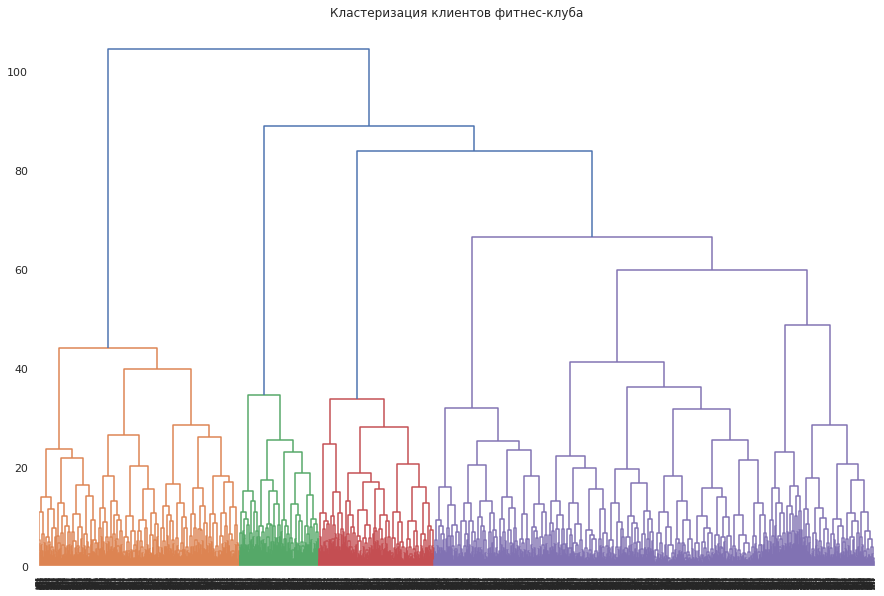

In [20]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-клуба')
plt.show() 

Согласно дендрограмме, аглоритм предлагает разделить клиентов на **4 кластера**. Мы видим что **фиолетовая** часть получилась значительно больше остальных, потенциально ее можно было бы разделить еще на **2 кластера** и получить в итоге **5 кластеров**, именно такое количество кластеров мы зададим для следующего алгоритма `K-Means`

**Модель кластеризации клиентов**

Обучим модель кластеризации алгоритмом `KMeans`

In [21]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(data_for_c)
data['cluster'] = labels

**Распределение признаков для кластеров**

Выведим средние значения признаков для кластеров

In [22]:
data.groupby('cluster').mean().T.style.background_gradient(cmap='viridis', axis=1).set_precision(2)

cluster,0,1,2,3,4
gender,0.51,0.51,0.47,0.51,0.52
near_location,0.84,0.84,0.86,0.82,0.88
partner,0.45,0.50,0.52,0.49,0.51
promo_friends,0.28,0.32,0.33,0.29,0.35
phone,0.90,0.90,0.93,0.91,0.90
contract_period,4.30,4.76,5.82,4.20,5.40
group_visits,0.41,0.42,0.43,0.39,0.43
age,28.97,29.40,29.85,28.91,29.34
avg_additional_charges_total,105.93,174.87,356.48,35.60,250.98
month_to_end_contract,4.00,4.38,5.38,3.86,5.00


Выведим графики для числовых признаков по кластерам

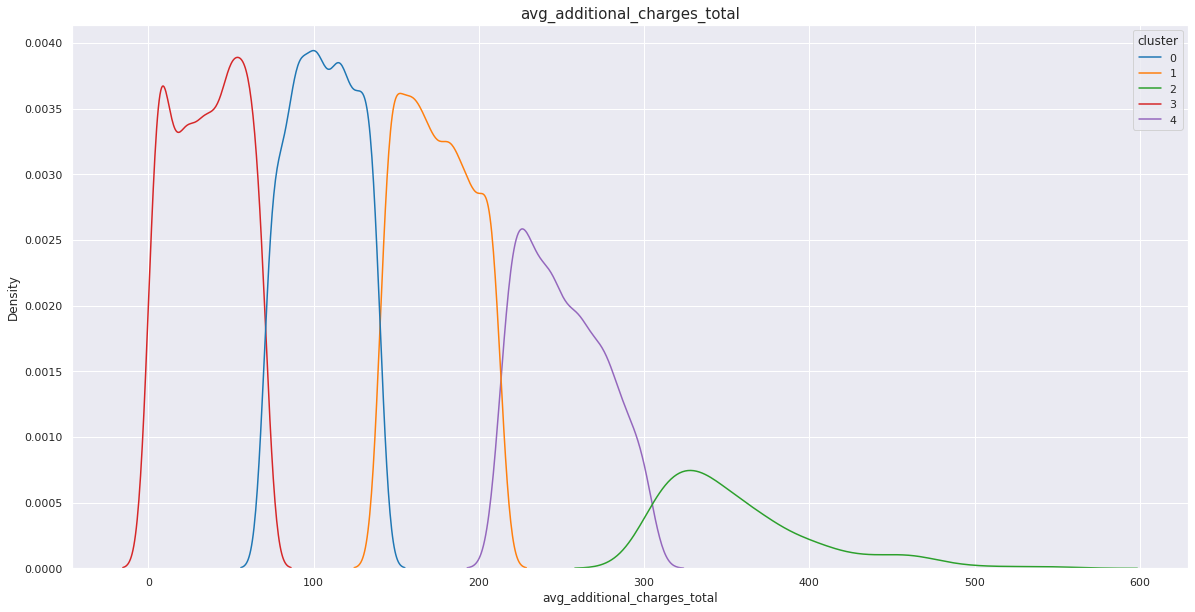

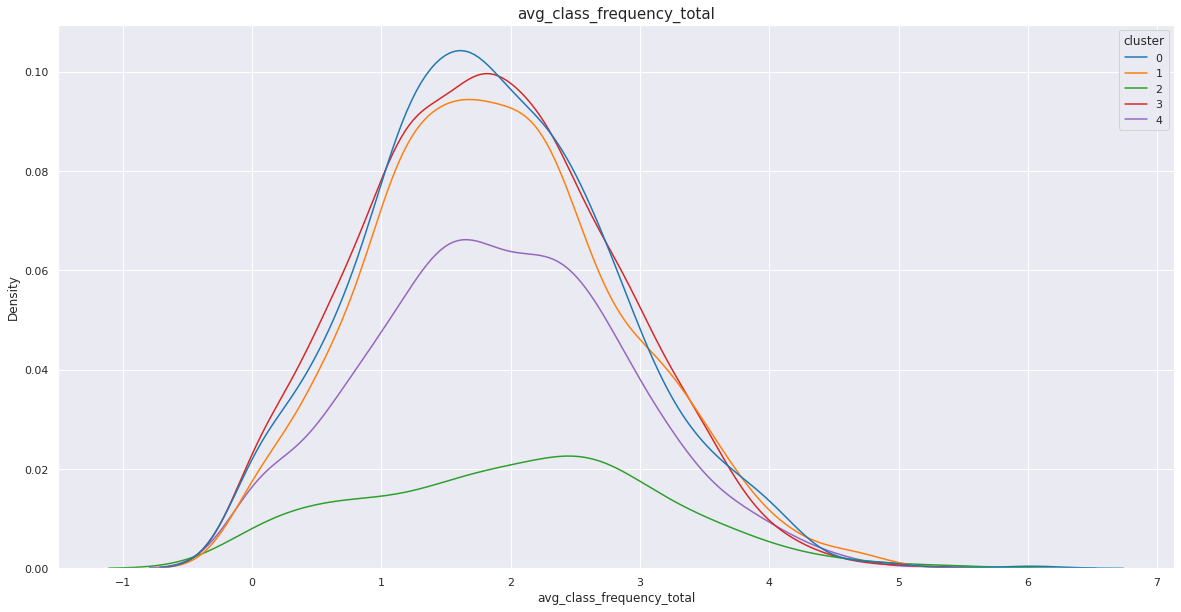

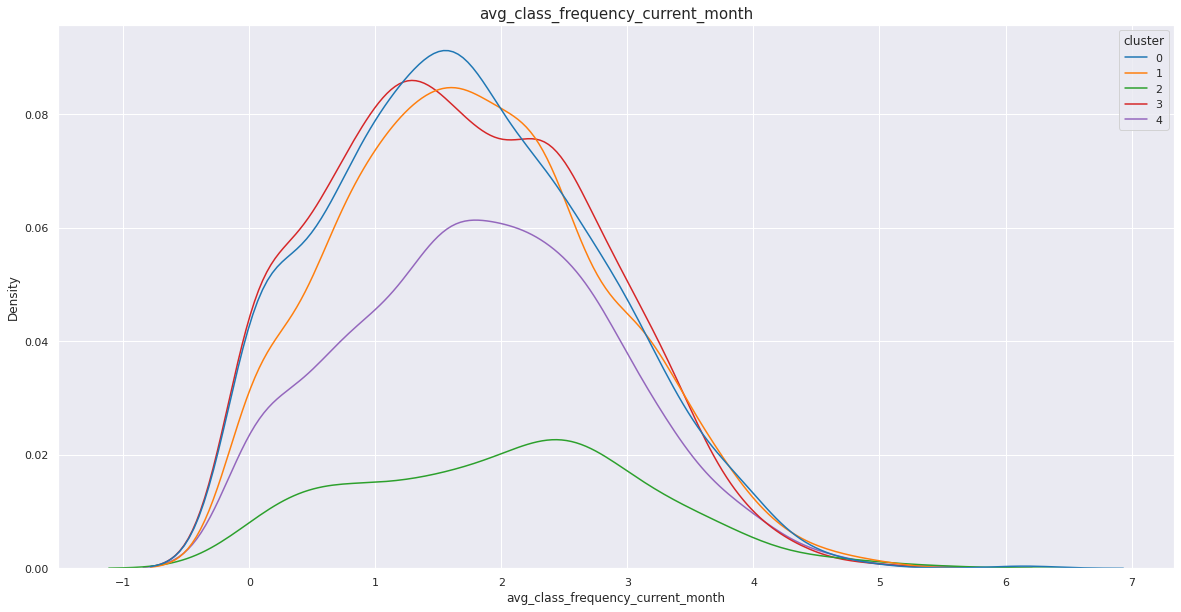

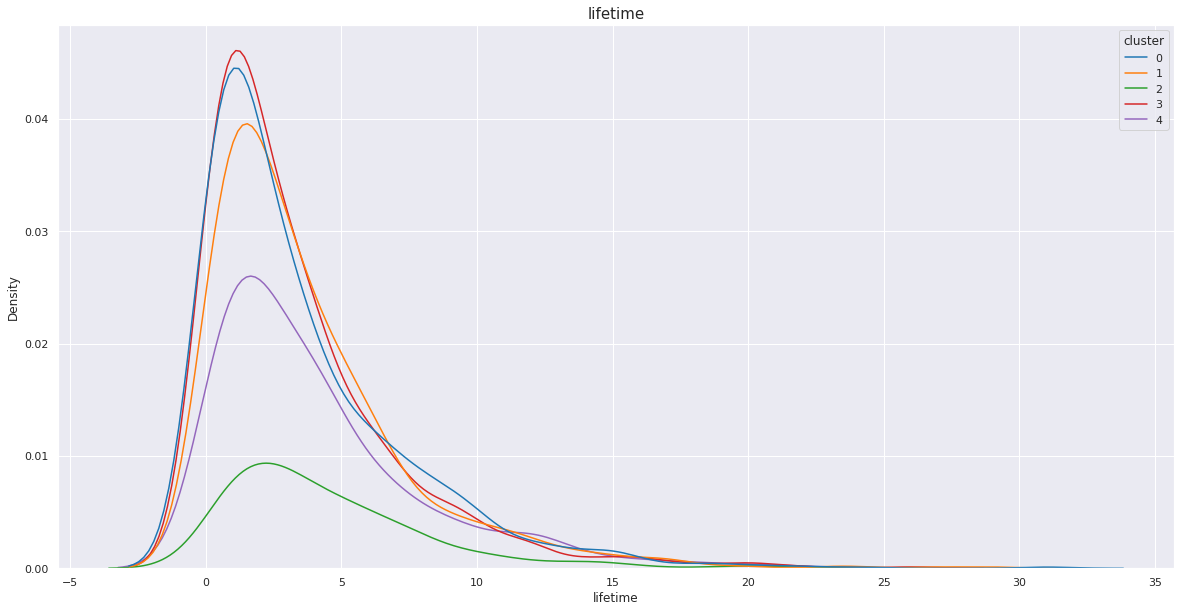

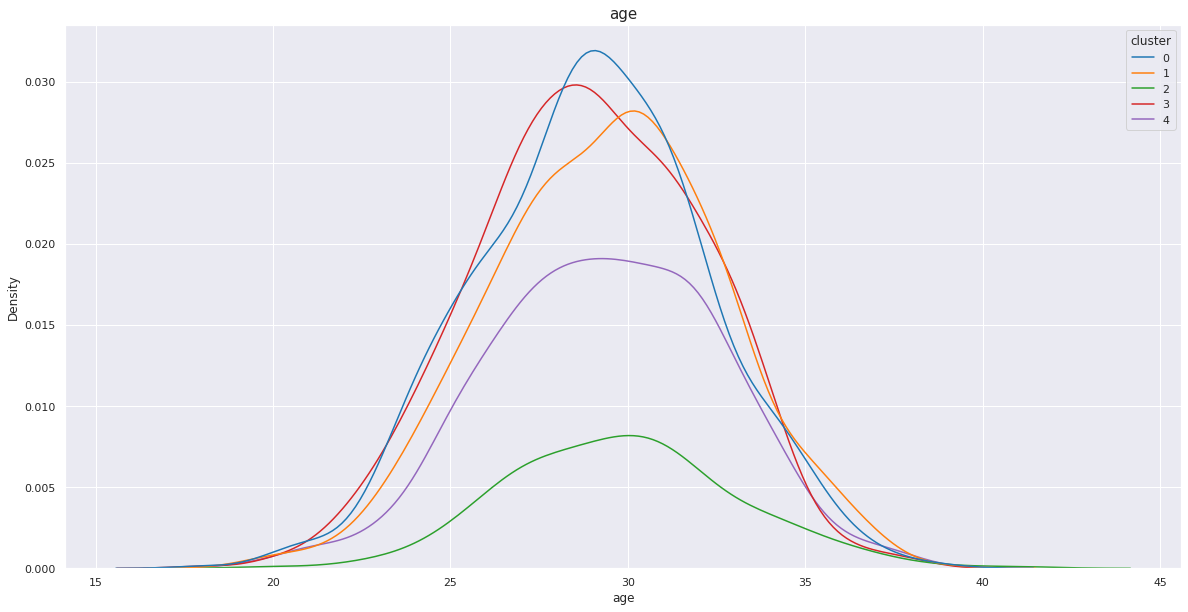

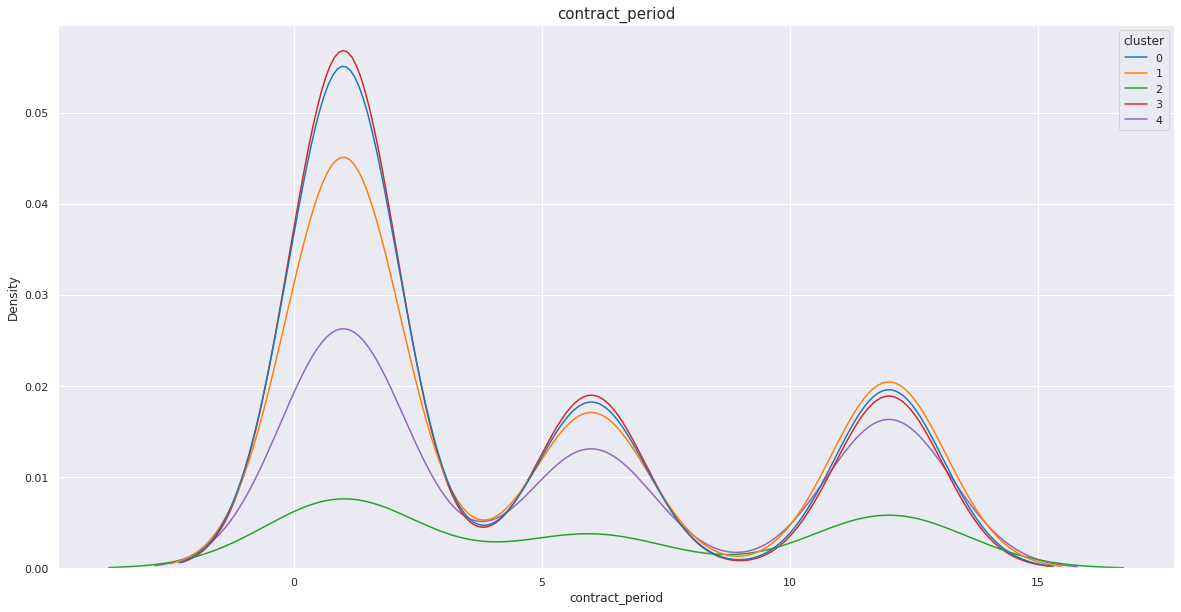

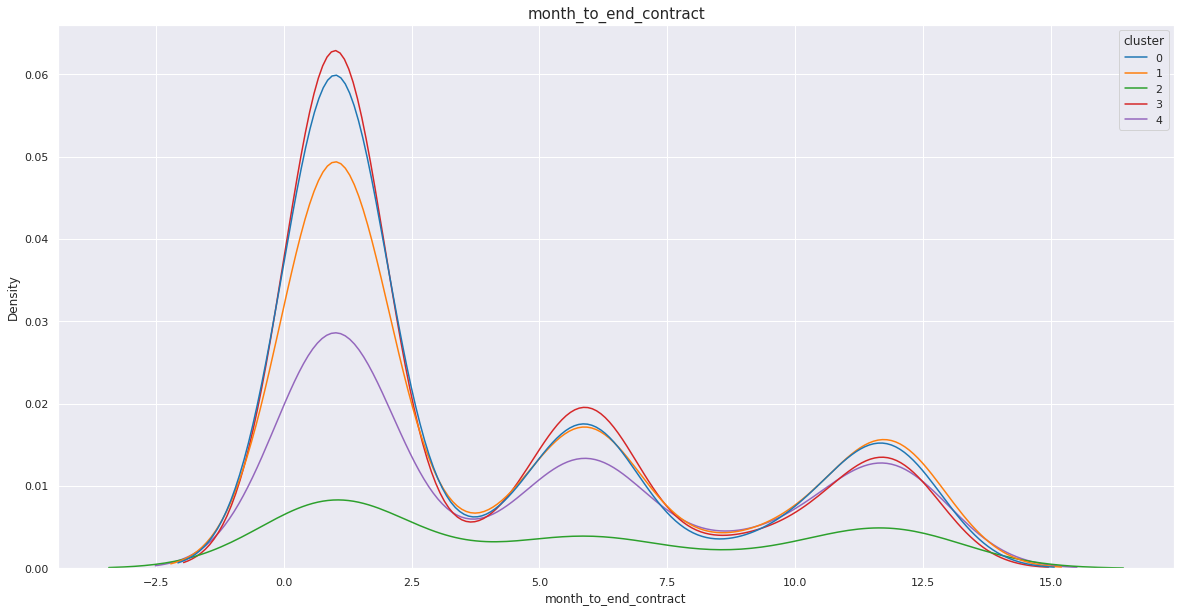

In [23]:
for column in ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']:
    plt.figure(figsize=(20, 10))
    plt.title(column, fontsize=15)   
    sns.kdeplot(data = data, x = column, hue = 'cluster', palette='tab10')
    sns.set_style('darkgrid')
    #plt.legend()
    plt.show()

Выведим графики для бинарных признаков по кластерам

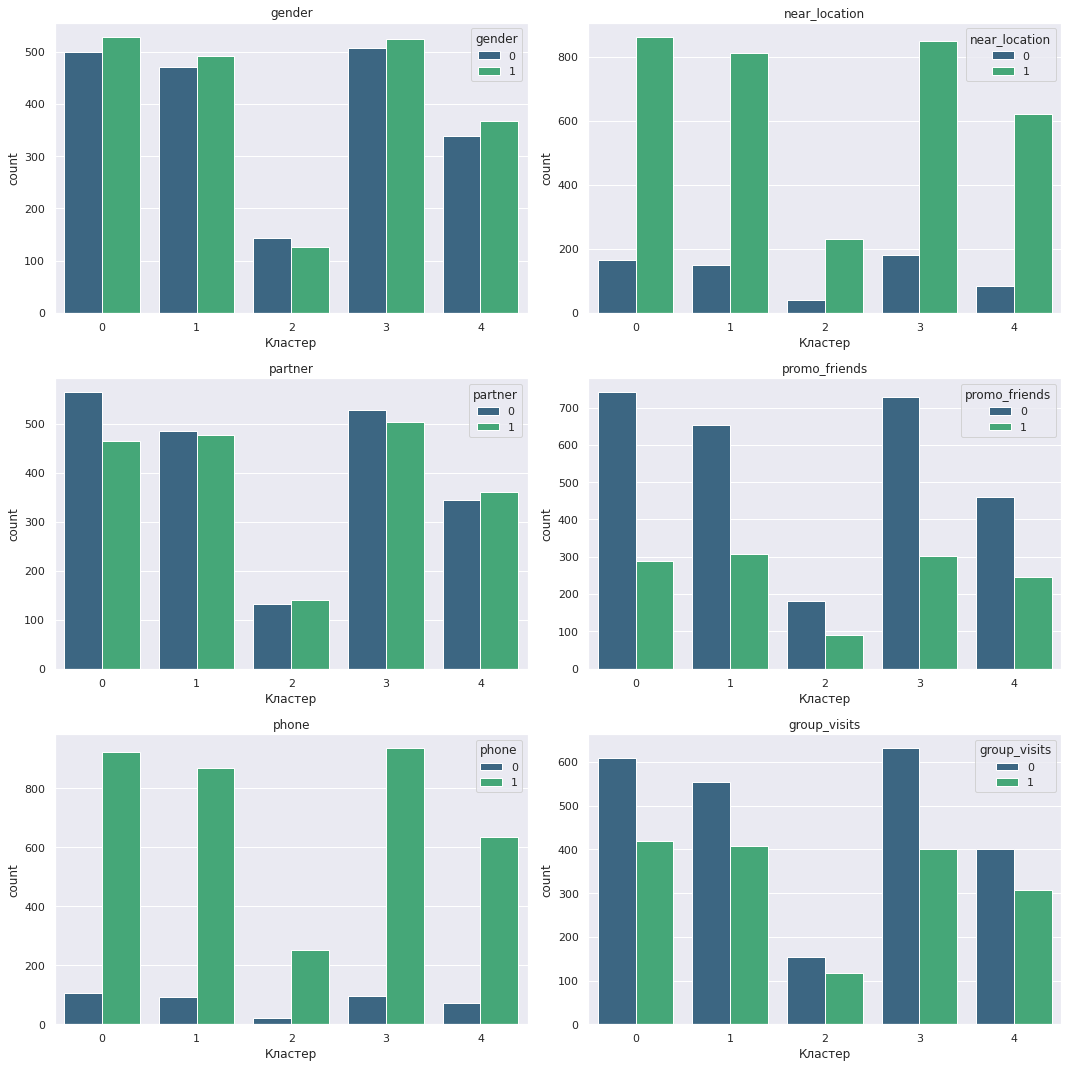

In [24]:
num_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

number_row = int(len(num_features)/2)

fig, ax = plt.subplots(nrows = number_row, ncols=2, figsize=(15, 15))
ax = ax.flatten()

for i in range(len(num_features)):
    sns.countplot(x='cluster', hue=num_features[i], data=data, ax=ax[i], palette='viridis')
    ax[i].set_title(f'{num_features[i]}')
    ax[i].set_xlabel('Кластер')

fig.tight_layout()
fig.show()

Выведим количества клиентов по кластерам 

In [25]:
data['cluster'].value_counts()

3    1032
0    1029
1     962
4     706
2     271
Name: cluster, dtype: int64

Выведим среднее значение доли ушедших клиентов в разбивке по кластерам

In [26]:
data.groupby('cluster').agg({'churn':'mean'}).sort_values(by='churn', ascending=False)

,churn
cluster,
3,0.349806
0,0.334305
1,0.226611
4,0.178470
2,0.044280


**Выводы**

* По распределению признаков в кластерах мы видим, что основной признак сегментации - суммарная выручка от продажи доп.услуг. Чем больше клиент использует дополнительные услуги, тем меньше вероятность оттока. Так же, у кластеров с высокой средней выручкой от доп.услуг (**кластеры 2 и 4**) самые высокие показатели **lifetime**, длительность абонемента (как и времени до окончания абонемента), частоты посещения фитнес-центра, посещения групповых занятий, партнерства, близости к фитнес-центру и приглашений от друзей. И кластеры **2 и 4** имеют самые низкие показатели оттока.

* В то время как кластеры с наибольшой долей оттока (**кластеры 0 и 3**) показывают наименьшие значения выручки с доп.услуг, реже пользуются групповыми занятиями, реже являются партнерами и реже приходят по приглашению друзей.

* В **кластер 1** попали клиенты-**"среднячки"**, имея средний показатель доли оттока со среднеми показатели остальных признаков.

* Следовательно, самый стабильный кластер к оттоку: **кластер 2**, имеет всего **4% оттока** - клиенты, которые часто ходят на тренировки, постоянно приобретают дополнительные услуги, имеют долгосрочные абонементы и тд., являясь малой группой постоянных клиентов. Так как в кластер попало всего **271 клиент.**

* В **кластер 4** попало **706 клиентов**, при доле оттока **17-18%** - клиенты, которые немного менее активны, чем клиенты из **кластера 2**. Они чаще живут/работают вбизи фитнес-центра, немного реже занимаются и меньше приобратают доп.услуг.

* В **кластер 1** попало **962 клиента**, при доле оттока **22%** - клиенты, которые начали стабильно ходить в фитнес-центр и пользоваться доп.услугами, но имеют среднюю активность. Среди этих клиентов много потенциальных постоянников, которые могут перейти в **кластеры 4 и 2.**

* **Кластеры 3 и 0**, имеют **1032 и 1029 клиентов** и долю оттока **35% и 33% соответственно**. У этих кластеров самые низкие показатели выручки от доп.услуг, реже всех посещают тренировки, имеют краткосрочные абонементы и пришли недавно.

# Общие выводы и рекомендации

**Общие выводы:**

**Изучение и предобработка данных:**

* Полученные данные в порядке, дубликатов и пропусков нету. Для исследования привели названия столбцов в единый вид.

**Прогнозирование оттока:**

* С помощью матрицы корреляции обнаружили две пары мультиколлиниарных признаков - **Длительность абонемента** и **Время окончания абонемента**, **Количество посещений** в неделю за всё время и **Количество посещений в неделю за предыдущий месяц**.

* С помощью Логистической Регрессии мы можем предсказывать отток с вероятность **90%.**

**При изучении данных смогли выделить следующие моменты:**

* Молодые клиенты чаще приобретают короткие абонементы и чаще уходят.Постоянными клиентами чаще становятся клиенты от **28-30 лет.**
* **Пол** клиента никак не влияет на **отток**.
* Чем дольше и чаще клиент посещает фитнес-центр, тем меньше вероятность оттока. Самый большой отток у клиентов, которые преобретают абонементы на **1-3 месяца**.
* Клиенты, которые приходят от организаций-партнеров, имеет в несколько раз меньшую долю оттока в сравнении с тем, кто приходит сам.
* Посещение групповых занятий и приглашение друзей уменьшают вероятность оттока.
* Клиенты у которых средняя частота посещений в неделю за месяц меньше 2 с высокой вероятностью не будут продлевать абонемент и уйдут.

**Кластеризация:**

**С помощью кластеризации выделили 5 основых кластеров клиентов:**
* **Кластер 1** - клиенты-**"среднячки"**. В кластер попало **962 клиента** с долей оттока **22%**. Клиенты, которые начали стабильно посещать фитнес-центр и пользоваться доп.услугами, но имеют среднию активность. Среди таких клиентов, большую долю можно перевести до клиентов-постоянников.

* **Кластер 2** - клиенты-постоянники-фанаты. Малая группа клиентов (**271 человека**) с оттоком всего **4%**. Для них характерны частые тренировки (**2 и более тренировки в неделю**), долгосрочные абонементы и большая выручка с доп.услуг.

* **Кластеры 3 и 0** - клиенты, которые только начали заниматься или занимаются редко/непостоянно. В сегмент входит **1032 и 1029 клиентов**, с долями оттока **35%** и **33%** соответственно. Между собой отличаются тем, что клиенты из **кластера 3** практически не пользуются доп.услугами, а из **кластера 0** либо берут на пробу разные услуги центра и больше ими не пользуются либо пользуются минимальным количеством доп.услуг.

* **Кластер 4** - клиенты-постоянники. В кластер попало **706 клиентов** с долей оттока **17-18%**. Клиенты показывают приблизительное поведение как и клиенты-фанаты (**кластер 2**), но немного меньше занимаются и приобретают меньше доп.услуг. Среди этого сегмента, явно большая доля потенциальных клиентов-фанатов.

**Рекоммендации:**

* Клиенты, которые приобретают абонемент на малый срок (**1-3 месяца**) в несколько раз чаще не продлевают абонементы и не возвращаются. Следовательно, необходимо мотивировать клиентов приобретать абонементы на 12 месяцев. Это позволит не только увеличить выручку с продажи абонементов, но и увеличить доход с доп.продаж услуг, а так же увеличивает шанс на то, что клиент продолжит пользоваться услугами фитнес-центра и пригласит своих друзей.


* Новых клиентов необходимо мотивировать на групповые занятия и приобретение долгосрочных абонементов, чтобы увеличить удержание клиента на более долгий срок, тем самым сформировать привычку посещения фитнес-центра.


* Следует добавить какие-либо бонусы или скидки на доп.услуги при покупке долгосрочных абонементов, чтобы стимулировать более частые посещения фитнес-центра, тем самым переводя клиентов в постоянников.


* Так же, стоит внедрить метрику NPS (**Net Promoter Score**) или её аналог TNPS, чтобы отслеживать лояльность клиентов, тем самым повысить качество индивидуального подхода и улучшить точность прогноза оттока.